<a href="https://colab.research.google.com/github/JulyMarc/YouTube_Comments_Intersection/blob/main/YouTube_Comments_Intersection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and etc

In [ ]:
pip install youtube_comment_downloader

In [2]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

In [3]:
from itertools import islice
from youtube_comment_downloader import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Video links parsing

In [5]:
# List of interested authors
authors = ['Max_Katz', 'khodorkovskyru','sobchak',
           'zhivoygvozd','Vladimir_Milov','yashin_russia', 'vdud']

In [6]:
# Parsing last video links on each author

l_links_on_video = []
for i in tqdm(authors):
  url = 'https://www.youtube.com/@' + i + '/videos'
  response = requests.get(url)
  html_content = response.content
  soup = BeautifulSoup(html_content, 'html.parser')
  scripts = soup.find_all('script')

  for script in scripts:
      if 'ytInitialData' in str(script):
          pattern = re.compile(r'"videoId":"(\w+)"')
          matches = re.findall(pattern, str(script))
          for match in matches:
            l_links_on_video.append([i,match])

100%|██████████| 7/7 [00:34<00:00,  4.91s/it]


In [7]:
df_links = pd.DataFrame(l_links_on_video).drop_duplicates()
df_links.reset_index(inplace = True)
df_links.drop('index', axis = 1, inplace = True)
df_links.columns = ['author','link']
df_links.shape

(177, 2)

In [8]:
df_links.head()

,author,link
0,Max_Katz,mkQxtD7T6Bo
1,Max_Katz,hyHpp9dVMQU
2,Max_Katz,gwrXzeKJpOM
3,Max_Katz,cDQDq_Ht9iY
4,Max_Katz,v822bgIIkdk


# Getting comment count

In [9]:
# Counting of comments on each video to estimate mean amount of downloading comments
l_comments_counts = []
for i in tqdm(df_links['link']):
  url = 'https://www.youtube.com/watch?v=' + i
  response = requests.get(url)
  html_content = response.content
  pos = str(html_content).find('commentCount')
  cnt = str(html_content)[pos:pos+50]
  l_comments_counts.append([i,cnt])

100%|██████████| 177/177 [02:00<00:00,  1.46it/s]


In [10]:
df_links['count'] = pd.DataFrame(l_comments_counts)[1].str.split('"', expand = True)[4].str[:-1].astype(float)

In [11]:
df_links.groupby('author')['count'].agg(['mean','median','max']).round(0).astype(int)

,mean,median,max
author,,,
Max_Katz,5,5,9
Vladimir_Milov,18,3,92
khodorkovskyru,4,4,8
sobchak,5,2,25
vdud,55,38,394
yashin_russia,10,9,37
zhivoygvozd,21,16,74


In [13]:
df_links.groupby('author')['count'].agg(['mean','median','max']).round(0).astype(int).mean()

mean      16.857143
median    11.000000
max       91.285714
dtype: float64

# Comments downloading

In [14]:
# # Loading dataframe if it already exists
# df_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/youtube_comments.csv')

<ipython-input-14-c17e42ea00dd>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/youtube_comments.csv')


In [17]:
downloader = YoutubeCommentDownloader()

In [18]:
## Downloading comments
# df_comments = pd.DataFrame()
# for i in tqdm(lost_links): #df_links['link']
#   comments = downloader.get_comments_from_url('https://www.youtube.com/watch?v=' + i, 
#                                               sort_by =  SORT_BY_POPULAR) #SORT_BY_POPULAR / SORT_BY_RECENT
#   l_comments = []
#   for comment in islice(comments, 10000):
#       l_comments.append(comment)
#   temp = pd.DataFrame(l_comments)
#   temp['link'] = i
#   df_comments = pd.concat([df_comments, temp])
#   df_comments.to_csv('/content/drive/MyDrive/Colab Notebooks/youtube_comments_lost.csv', index=False)

100%|██████████| 32/32 [1:11:03<00:00, 133.22s/it]


In [29]:
df_comments.shape

(531854, 12)

In [32]:
df_comments.columns

Index(['cid', 'text', 'time', 'author', 'channel', 'votes', 'photo', 'heart',
       'reply', 'time_parsed', 'link', 'paid'],
      dtype='object')

In [38]:
df_comments.head(3)

,cid,text,time,author,channel,votes,photo,heart,reply,time_parsed,link,paid
0,UgxcwIb_m7xdaZXM82B4AaABAg,Вместо родитель номер один и родитель номер дв...,11 hours ago,Pavel Degtyarev,UCRAF7PKsw5C7-f4TNrm35tA,1.4K,https://yt3.ggpht.com/ytc/AGIKgqMEvBRjpMDmbWGR...,False,False,1.682519e+09,hyHpp9dVMQU,NaN
1,UgwZKXnkXZbrwduAYE54AaABAg,"После того, как Песков заявил, что двойников у...",8 hours ago,Ксения Астрейко,UCERLdhjjeJ4JxPHAqfKWrkA,868,https://yt3.ggpht.com/ytc/AGIKgqOt-jBmPv2xj90K...,False,False,1.682530e+09,hyHpp9dVMQU,NaN
2,Ugzad9aAcMoZ3cfho-h4AaABAg,"Самое страшное в двойниках, что оригинал может...",8 hours ago,TheStrang007,UCXskLwGJl9c-pFx9fFEjY9Q,380,https://yt3.ggpht.com/ytc/AGIKgqMDTg5LF_ClrCNt...,False,False,1.682530e+09,hyHpp9dVMQU,NaN


# Analysis

## Baseline calc

In [15]:
# DataFrame for exercises  
df_baseline = df_comments.drop('author',axis =1).merge(df_links, how = 'left', on = 'link')\
.drop_duplicates(['author','channel','link'])

In [16]:
# Calculating of baseline (intersections between videos of same author)
l_baselines = []
for i in tqdm(df_baseline['author'].unique()):
  author_links = df_baseline[df_baseline['author'] == i]['link'].unique()
  number_of_videos = len(df_baseline[df_baseline['author'] == i]['link'].unique())
  for j in range(number_of_videos-1):
    for k in range(j+1, number_of_videos):
        l_baselines.append([i, author_links[j], author_links[k],
                            df_baseline[df_baseline['link'] == author_links[j]]['channel'].\
                            isin(df_baseline[df_baseline['link'] == author_links[k]]['channel']).mean()])


100%|██████████| 8/8 [02:02<00:00, 15.36s/it]


<Axes: title={'center': 'Intersection'}, ylabel='author'>

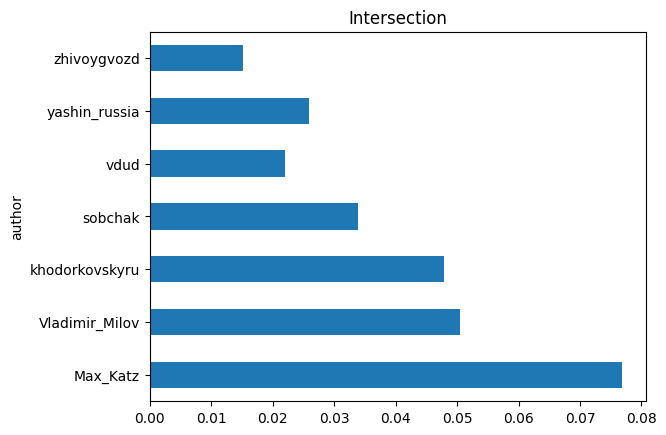

In [17]:
l_baselines = pd.DataFrame(l_baselines)
l_baselines.columns = ['author','v1','v2','share']

l_baselines.groupby('author')['share'].mean().plot.barh(title = 'Intersection')

## Main calc

In [18]:
# DataFrame for exercises  
df_temp = df_comments.drop('author',axis =1).merge(df_links, how = 'left', on = 'link')

In [19]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531854 entries, 0 to 531853
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   cid          531854 non-null  object 
 1   text         531854 non-null  object 
 2   time         531854 non-null  object 
 3   channel      531853 non-null  object 
 4   votes        531854 non-null  object 
 5   photo        531854 non-null  object 
 6   heart        531854 non-null  bool   
 7   reply        531854 non-null  bool   
 8   time_parsed  531854 non-null  float64
 9   link         531854 non-null  object 
 10  paid         138 non-null     object 
 11  author       414773 non-null  object 
 12  count        414773 non-null  float64
dtypes: bool(2), float64(2), object(9)
memory usage: 49.7+ MB


In [20]:
df_temp.nunique()

cid            531854
text           508626
time              190
channel        221704
votes            1079
photo          185136
heart               2
reply               2
time_parsed    531854
link              229
paid               61
author              7
count             101
dtype: int64

In [21]:
# Dropping duplicates of comments to specific author from the same channel
df_temp = df_temp.drop_duplicates(['author','channel'])
# Discovering author's minimum number of video
df_temp.drop_duplicates(['author','link']).groupby('author')['link'].count().min()

20

In [22]:
top_links = df_temp.drop_duplicates(['author','link']).groupby('author').head(21)['link']
df_temp = df_temp[df_temp['link'].isin(top_links)]
df_temp.shape

(168727, 13)

In [23]:
l_union = []
for i in df_temp['author'].unique():
  for j in df_temp['author'].unique():
    if i != j:
      l_union.append([i, j, df_temp[(df_temp['author'] == i) & (df_temp['link'].isin(top_links))]['channel'].shape[0],
                    df_temp[df_temp['author'] == i]['channel'].isin(df_temp[df_temp['author'] == j]['channel']).sum()])
l_union = pd.DataFrame(l_union)
l_union.columns = ['in','out','total','out_count']
l_union['share'] = l_union['out_count']/l_union['total']

In [25]:
l_union.head(6)

,in,out,total,out_count,share
0,Max_Katz,khodorkovskyru,23537,1672,0.071037
1,Max_Katz,sobchak,23537,766,0.032545
2,Max_Katz,zhivoygvozd,23537,345,0.014658
3,Max_Katz,Vladimir_Milov,23537,1035,0.043973
4,Max_Katz,yashin_russia,23537,1533,0.065131
5,Max_Katz,vdud,23537,1736,0.073756


In [26]:
# Russian names
d_authors = {'Max_Katz':"Katz",
           'khodorkovskyru':"Khodorkovsky",
           'sobchak':"Sobchak",
           'NavalnyRu':"Navalny",
           'NavalnyLiveChannel':"Navalny Live",
           'zhivoygvozd':"Venedictov",
           'Vladimir_Milov':"Milov",
           'yashin_russia':"Yashin",
           'vdud':'Dud'}

In [27]:
l_union['name'] = l_union['out'].map(d_authors)

## Horisontal bar

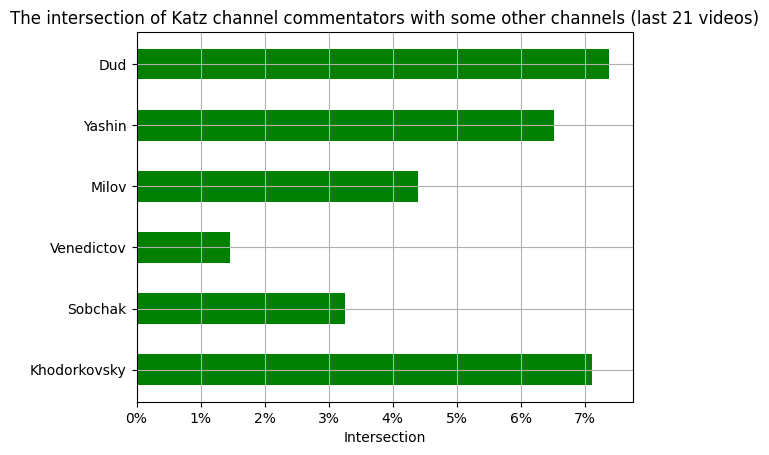

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Define data
y = l_union[l_union['in'] == 'Max_Katz']['name']
x = l_union[l_union['in'] == 'Max_Katz']['share']*100

# Create horizontal bar histogram
plt.barh(y, x, color='green', height=0.5)


# Customize x-axis
fmt = '%.0f%%' # Format y-axis as percentage with no decimal places
xticks = mtick.FormatStrFormatter(fmt)
plt.gca().xaxis.set_major_formatter(xticks)

# Customize parameters
plt.title('The intersection of Katz channel commentators with some other channels (last 21 videos)')
plt.xlabel('Intersection')
# plt.xlim(0, 10)
plt.grid(True)

# Show plot
plt.show()


## Venn Diagram

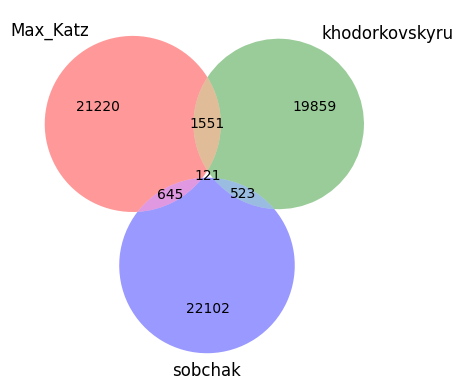

In [30]:
from matplotlib_venn import venn3
top_3_authors = ['Max_Katz','khodorkovskyru','sobchak']
# Define sets
set0 = set(df_temp[df_temp['author'] == top_3_authors[0]]['channel'])
set1 = set(df_temp[df_temp['author'] == top_3_authors[1]]['channel'])
set2 = set(df_temp[df_temp['author'] == top_3_authors[2]]['channel'])

# Draw Venn diagram
venn3([set0, set1, set2], set_labels=(top_3_authors))

# Show plot
plt.show()